In [1]:
# Scikit-learn pipeline and preprocessing imports
from sklearn.pipeline import Pipeline  # Create sequential data processing pipelines
from sklearn.compose import ColumnTransformer  # Apply different transformers to different columns
from category_encoders import TargetEncoder  # Encode categorical variables using target values
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder  # Feature scaling and encoding
from sklearn.model_selection import KFold  # K-fold cross-validation
from sklearn.model_selection import train_test_split  # Split data into train/test sets
from sklearn.metrics import make_scorer  # Create custom scoring functions
from lightgbm import LGBMRegressor  # LightGBM gradient boosting regressor
import optuna  # Hyperparameter optimization framework
from sklearn.base import clone  # Clone scikit-learn estimators

# Data manipulation and analysis
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical computing
import joblib        # Model serialization
import pickle        # Python object serialization

# Visualization libraries
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns           # Statistical data visualization

# Model evaluation and selection
from sklearn.model_selection import learning_curve, KFold  # Learning curves and cross-validation
from sklearn.metrics import mean_squared_error, r2_score  # Regression metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score  # Model selection tools
from sklearn.metrics import mean_squared_error  # Mean squared error metric
from xgboost import XGBRegressor  # XGBoost gradient boosting regressor

# System and utility imports
import sys  # System-specific parameters and functions
import warnings  # Warning control
warnings.filterwarnings('ignore')  # Suppress warning messages
import os   # Operating system interface

# Add project path for custom module imports
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

# Custom project modules
from src.data.data_loader import load_raw_data  # Load raw data utility
from src.features.feature_engineering import FeatureEngineering, FlagClusteringTransformer, PreprocessingFeaturesTransformer, PreprocessingFeatures  # Feature engineering classes
from category_encoders import TargetEncoder  # Target encoding for categorical variables

In [2]:
# Load raw data from CSV file
# This loads the original dataset containing vehicle advertisement information and lead counts
raw_data = load_raw_data('../../data/raw/raw_data.csv')

2025-08-13 10:04:06,635 - src.data.data_loader - INFO - Successfully loaded 48665 rows from ../../data/raw/raw_data.csv


In [13]:
# Define features to be removed from the dataset
# These features were identified as having low importance or causing overfitting
feat_to_drop = [
    "cd_type_individual",                   # Individual type code - low predictive power
    "cd_advertise",                         # Advertisement code - redundant identifier
    "cd_client",                            # Client code - privacy/data leakage concern
    "flg_rain_sensor",                      # Rain sensor flag - low importance
    "flg_diesel",                           # Diesel fuel flag - redundant with fuel_type
    "flg_eletrico",                         # Electric flag - rare/insufficient data
    "flg_benzina",                          # Benzina fuel flag - redundant with fuel_type
    "flg_pcd",                              # PCD flag - insufficient data
    "flg_trade_in",                         # Trade-in flag - low importance
    "flg_armored",                          # Armored vehicle flag - rare cases
    "flg_factory_warranty",                 # Factory warranty flag - low importance
    "flg_all_dealership_schedule_vehicle",  # Dealership schedule flag - low importance
    "flg_all_dealership_services",          # Dealership services flag - low importance
    "flg_single_owner",                     # Single owner flag - covered by 'owner' column
    "priority",                             # Priority field - business logic, not predictive
    "cd_model_vehicle",                     # Vehicle model code - too granular
    "cd_version_vehicle",                   # Vehicle version code - too granular
    "flg_lincese",                          # License flag - data quality issues
    "flg_tax_paid",                         # Tax paid flag - low importance
    "n_doors",                              # Number of doors - low importance
    "flg_alloy_wheels",                     # Alloy wheels flag - low importance
    "flg_gas_natural",                      # Natural gas flag - rare cases
]

# Create preprocessing pipeline with two main stages
pipeline_pre = Pipeline(
    [
        (
            "preprocessing",  # First stage: basic preprocessing
            PreprocessingFeaturesTransformer(
                location_col="city_state",                    # Column containing city/state information
                fuel_type_column="fuel_type",                 # Column containing fuel type information
                cols_to_drop=feat_to_drop,                    # Features to remove from dataset
                outlier_columns=["vl_advertise", "km_vehicle"],  # Columns to apply outlier treatment
            ),
        ),
        (
            "feat_engineering",  # Second stage: feature engineering
            FlagClusteringTransformer(
                feature_flag_cols=[                           # Binary feature flags to cluster/group
                    "flg_gasolina",          # Gasoline fuel flag
                    "flg_electric_locks",    # Electric locks flag
                    "flg_air_conditioning",  # Air conditioning flag
                    "flg_electric_windows",  # Electric windows flag
                    "flg_rear_defogger",     # Rear defogger flag
                    "flg_heater",            # Heater flag
                    "flg_alarm",             # Alarm system flag
                    "flg_airbag",            # Airbag flag
                    "flg_abs",               # ABS brakes flag
                    "flg_alcool",             # Alcohol flag
                    "flg_leather_seats",      # Leather seats flag
                    "flg_parking_sensor",     # Parking sensor flag
                ]
            ),
        ),
    ]
)

In [14]:
# Apply the preprocessing pipeline to the raw data
# This will: 1) Remove unwanted features, 2) Handle outliers, 3) Engineer new features, 4) Cluster binary flags
df_processed = pipeline_pre.fit_transform(raw_data)

2025-08-13 10:45:27,517 - src.features.feature_engineering - INFO - 📈 Numerical features: 5
2025-08-13 10:45:27,525 - src.features.feature_engineering - INFO - 🏷️ Categorical features: 35
2025-08-13 10:45:27,528 - src.features.feature_engineering - INFO - 🎯 Target variable: ['flg_leads', 'leads']
2025-08-13 10:45:27,530 - src.features.feature_engineering - INFO - Runnig location split...
2025-08-13 10:45:27,525 - src.features.feature_engineering - INFO - 🏷️ Categorical features: 35
2025-08-13 10:45:27,528 - src.features.feature_engineering - INFO - 🎯 Target variable: ['flg_leads', 'leads']
2025-08-13 10:45:27,530 - src.features.feature_engineering - INFO - Runnig location split...
2025-08-13 10:45:30,385 - src.features.feature_engineering - INFO - Converting flag columns to integer type...
2025-08-13 10:45:30,385 - src.features.feature_engineering - INFO - Converting flag columns to integer type...
2025-08-13 10:45:30,654 - src.features.feature_engineering - INFO - Flag columns convert

In [15]:
# Display the final column names after preprocessing
# This shows which features remain after cleaning and feature engineering
df_processed.columns

Index(['leads', 'views', 'phone_clicks', 'cd_vehicle_brand', 'year_model',
       'zip_2dig', 'vl_advertise', 'n_photos', 'km_vehicle', 'vl_market',
       'transmission_type', 'city', 'state', 'flag_cluster'],
      dtype='object')

In [16]:
# Prepare features and target variable for modeling
X = df_processed.drop('leads', axis=1)  # Features: all columns except the target variable
y = df_processed['leads']              # Target: number of leads generated

# Split data into training and testing sets
# 80% for training, 20% for testing, with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display column names to verify all required columns are present
print("Columns in X_train:", X_train.columns)

# Create the machine learning pipeline with encoding and model stages
pipeline = Pipeline(steps=[
    ('encoding', ColumnTransformer(  # Apply different encoders to different column types
        transformers=[
            # Target encode city column with smoothing to prevent overfitting
            ('city', TargetEncoder(cols=['city'], smoothing=0.5, min_samples_leaf=1000), ['city']),
            # Target encode state column with different smoothing parameters
            ('state', TargetEncoder(cols=['state'], smoothing=5, min_samples_leaf=500), ['state']),
            # Standardize numerical features to have mean=0 and std=1
            ('scaler', StandardScaler(), ['views', 'phone_clicks', 'vl_advertise', 'km_vehicle', 'vl_market']),
            # Ordinally encode transmission type (Manual < Automatic hierarchy)
            ('transmission', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['transmission_type'])
        ],
        remainder='passthrough'  # Keep all other columns unchanged (binary flags, etc.)
    )),
    # LightGBM regressor with initial hyperparameters
    ('model', LGBMRegressor(
        learning_rate=0.01,    # Small learning rate for stable training
        reg_alpha=1,           # L1 regularization to prevent overfitting
        num_leaves=20,         # Number of leaves in each tree (complexity control)
        max_depth=10,          # Maximum tree depth
        n_estimators=300,      # Number of boosting rounds
    ))
])

# Set up 5-fold cross-validation for robust model evaluation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Columns in X_train: Index(['views', 'phone_clicks', 'cd_vehicle_brand', 'year_model', 'zip_2dig',
       'vl_advertise', 'n_photos', 'km_vehicle', 'vl_market',
       'transmission_type', 'city', 'state', 'flag_cluster'],
      dtype='object')


In [60]:
import optuna.integration.lightgbm as lgb

prep = clone(pipeline.named_steps["encoding"])

# Fit the preprocessing pipeline on training data and transform both sets
prep.fit(X, y)           # Learn encoding parameters from training data only
X_tr = prep.transform(X_train)       # Transform training features
X_te = prep.transform(X_test) 


dtrain = lgb.Dataset(X_tr, label=y_train)
# dvalid = lgb.Dataset(X_te, label=y_test)

params = {
    "objective": "regression",
    "metric": "mean_squared_error",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

model = lgb.LightGBMTunerCV(
    params,
    dtrain,
    folds=kf
)

model.run()
print("Best score:", model.best_score)
best_params = model.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

min_child_samples, val_score: 42.602899: 100%|##########| 5/5 [00:47<00:00,  9.43s/it]

Best score: 42.602898952811145
Best params: {'objective': 'regression', 'metric': 'l2', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 4.027680366813042e-06, 'lambda_l2': 5.6781791482583125e-05, 'num_leaves': 7, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
  Params: 
    objective: regression
    metric: l2
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 4.027680366813042e-06
    lambda_l2: 5.6781791482583125e-05
    num_leaves: 7
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [55]:
# Calculate baseline performance using simple mean prediction
# This serves as a reference point to measure model improvement
baseline_pred = np.full_like(y_train, y_train.mean(), dtype=float)  # Predict mean for all samples
baseline_mse = np.mean((y_train - baseline_pred) ** 2)              # Calculate baseline MSE

print("MSE baseline:", baseline_mse)  # Display baseline performance

MSE baseline: 135.5174330920903


## Learning Curve Analysis and Overfitting Assessment

Let's plot the learning curve to evaluate if there's overfitting/underfitting and also reinforce the analysis with a scatter plot of actual vs predicted values.

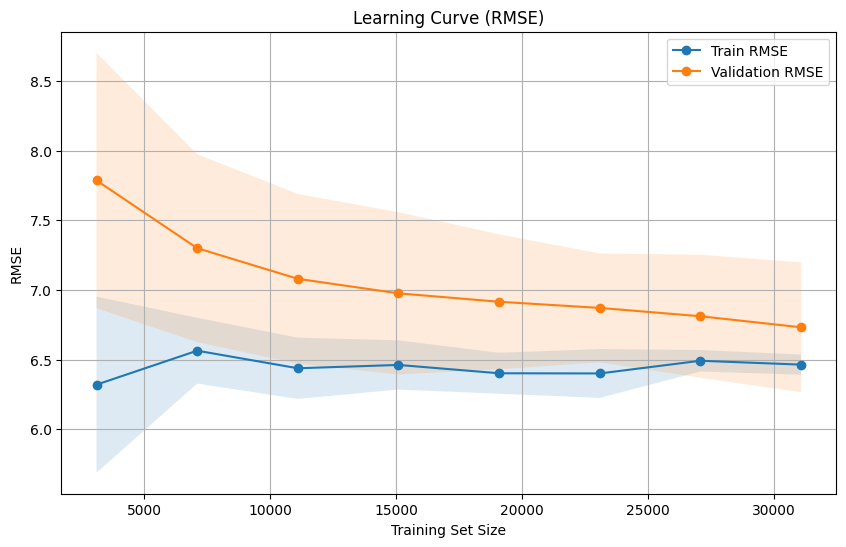

✅ No clear signs at last point: gap=0.268, gap/train=4.2% (≤ 15%)
Test: RMSE=6.688 | MSE=44.732 | R²=0.704
Train: RMSE=6.688 | MSE=44.732 | R²=0.704


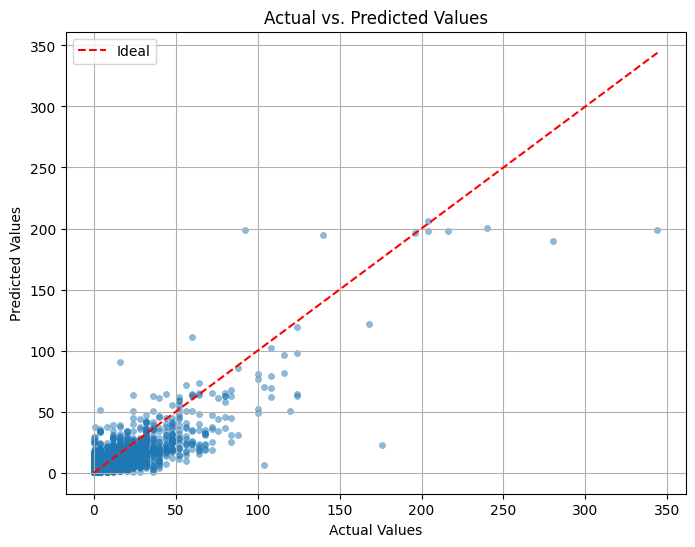

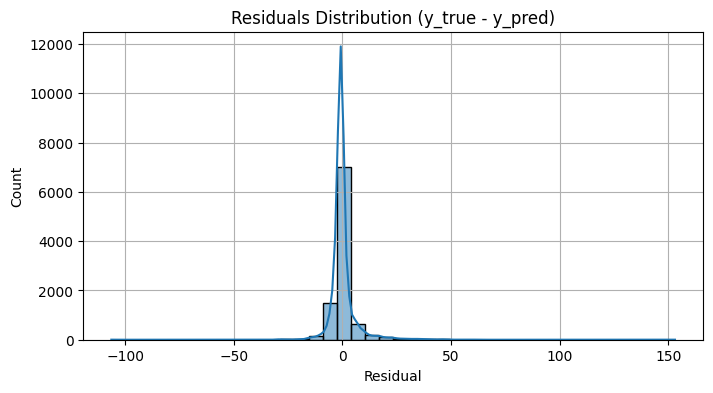

In [61]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== 1) Learning curve (RMSE) =====
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipeline.named_steps['model'].set_params(**best_params)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_train, y=y_train,
    cv=cv,
    scoring='neg_root_mean_squared_error',  
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1,
    shuffle=True,
    random_state=42,
    return_times=False
)

train_rmse = -train_scores
test_rmse  = -test_scores

train_mean = train_rmse.mean(axis=1)
train_std  = train_rmse.std(axis=1)
test_mean  = test_rmse.mean(axis=1)
test_std   = test_rmse.std(axis=1)

gap = test_mean - train_mean
gap_ratio = gap / np.maximum(train_mean, 1e-9)  

threshold = 0.15
min_consecutive = 2
start_idx = None
streak = 0
for i in range(len(train_sizes)):
    if gap_ratio[i] > threshold:
        streak += 1
        if streak >= min_consecutive:
            start_idx = i - min_consecutive + 1
            break
    else:
        streak = 0

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_mean, 'o-', label='Validation RMSE')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.fill_between(train_sizes, test_mean - test_std,   test_mean + test_std,   alpha=0.15)
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve (RMSE)')
plt.grid(True)
plt.legend()

if start_idx is not None:
    x0 = train_sizes[start_idx]
    y0 = test_mean[start_idx]
    plt.axvline(x0, linestyle='--', alpha=0.6)
    plt.annotate(
        f'Probable overfitting start\n(gap > {int(threshold*100)}%)',
        xy=(x0, y0),
        xytext=(x0, y0 + (test_mean.max()-test_mean.min())*0.15),
        arrowprops=dict(arrowstyle='->', lw=1),
        ha='center'
    )
plt.show()

last_gap = gap[-1]
last_ratio = gap_ratio[-1]
if last_ratio > threshold:
    print(f"⚠️ Possible overfitting (last point): gap={last_gap:.3f}, gap/train={last_ratio:.1%} (> {threshold:.0%})")
else:
    print(f"✅ No clear signs at last point: gap={last_gap:.3f}, gap/train={last_ratio:.1%} (≤ {threshold:.0%})")

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)
print(f"Test: RMSE={rmse:.3f} | MSE={mse:.3f} | R²={r2:.3f}")
print(f"Train: RMSE={rmse:.3f} | MSE={mse:.3f} | R²={r2:.3f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, s=20, edgecolor=None)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# (Optional) Residuals
res = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(res, bins=40, kde=True)
plt.title('Residuals Distribution (y_true - y_pred)')
plt.xlabel('Residual')
plt.grid(True)
plt.show()

## 📊 Feature Importance Analysis

Let's analyze which features are most important for predicting leads according to the trained LightGBM model.

Number of features: 13
Number of importance scores: 13
🔥 TOP 15 MOST IMPORTANT FEATURES:
 1. phone_clicks                  1522
 2. zip_2dig                       441
 3. vl_advertise                   431
 4. km_vehicle                     427
 5. cd_vehicle_brand               367
 6. vl_market                      349
 7. year_model                     328
 8. views                          324
 9. city_encoded                   298
10. state_encoded                  181
11. n_photos                       154
12. transmission_type_encoded      128
13. flag_cluster                    72


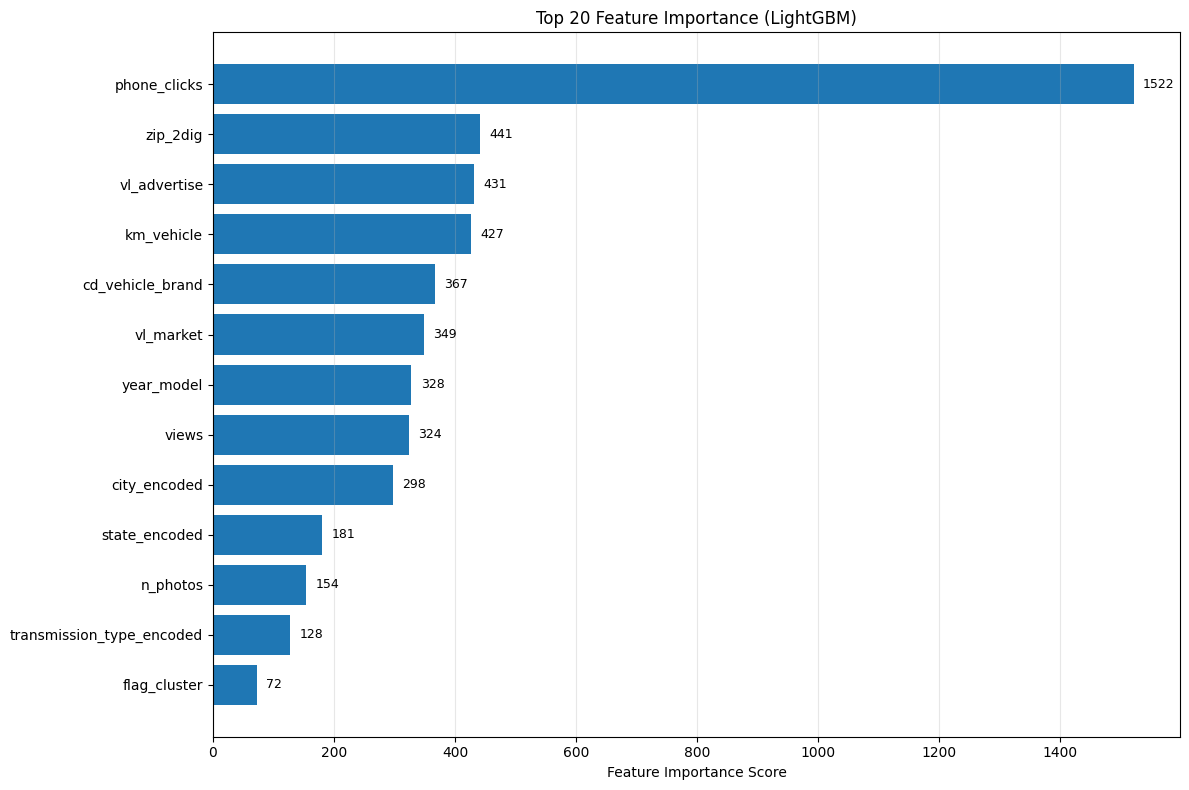


📈 FEATURE IMPORTANCE STATISTICS:
Total importance score: 5022
Top 5 features contribute: 63.5% of total importance
Top 10 features contribute: 93.0% of total importance
Top 15 features contribute: 96.0% of total importance


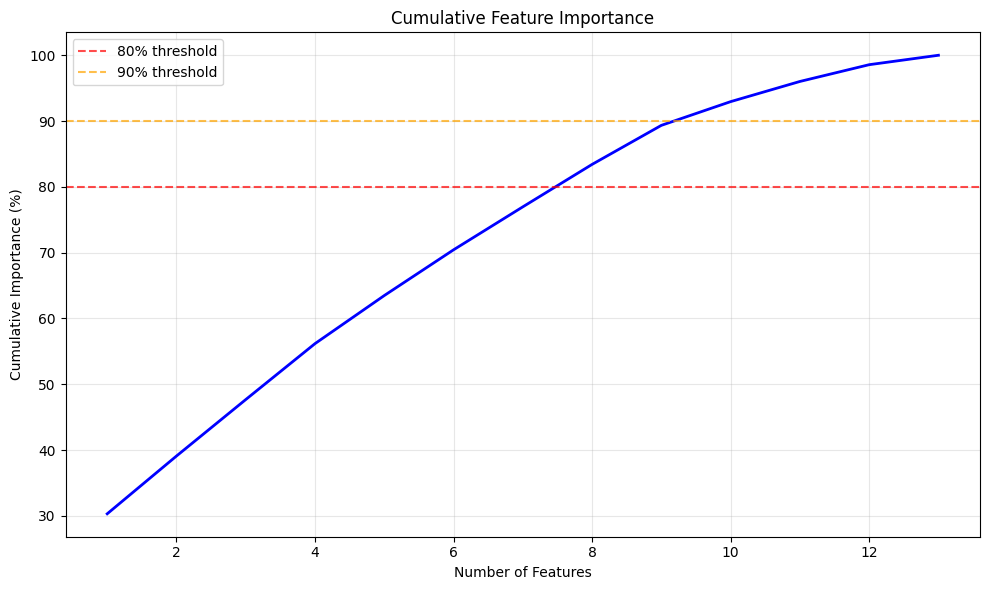

💡 INSIGHTS:
• 3 features needed to capture 80% of importance
• 2 features needed to capture 90% of importance
• Model could potentially be simplified using top 3-2 features


In [62]:
# Extract feature importance from the trained LightGBM model
# Get the trained model from the pipeline
trained_model = pipeline.named_steps['model']

# Get feature importance scores (based on number of times feature is used to split)
feature_importance = trained_model.feature_importances_

# Get feature names after preprocessing transformation
# We need to get the column names from the transformed data
feature_names = []

# Get the column transformer
column_transformer = pipeline.named_steps['encoding']

# Get feature names from each transformer
transformers = column_transformer.transformers_

# Build feature names list
for name, transformer, columns in transformers:
    if name == 'city':
        feature_names.extend(['city_encoded'])
    elif name == 'state':
        feature_names.extend(['state_encoded'])
    elif name == 'scaler':
        feature_names.extend(columns)  # ['views', 'phone_clicks', 'vl_advertise', 'km_vehicle', 'vl_market']
    elif name == 'transmission':
        feature_names.extend(['transmission_type_encoded'])

# Add the passthrough columns (remaining columns after preprocessing)
# These are typically the binary flags and other unchanged columns
passthrough_cols = []
all_input_cols = X_train.columns.tolist()
processed_cols = ['city', 'state', 'views', 'phone_clicks', 'vl_advertise', 'km_vehicle', 'vl_market', 'transmission_type']
for col in all_input_cols:
    if col not in processed_cols:
        passthrough_cols.append(col)

feature_names.extend(passthrough_cols)

# Ensure we have the correct number of features
print(f"Number of features: {len(feature_names)}")
print(f"Number of importance scores: {len(feature_importance)}")

# Create DataFrame with feature importance
if len(feature_names) == len(feature_importance):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
else:
    # Fallback: use generic feature names
    importance_df = pd.DataFrame({
        'feature': [f'feature_{i}' for i in range(len(feature_importance))],
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

# Display top 15 most important features
print("🔥 TOP 15 MOST IMPORTANT FEATURES:")
print("="*50)
for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25} {row['importance']:>8.0f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)  # Show top 20 features

# Create horizontal bar plot
bars = plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # Highest importance at top

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + max(top_features['importance']) * 0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', 
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

# Calculate and display feature importance statistics
total_importance = importance_df['importance'].sum()
cumulative_importance = importance_df['importance'].cumsum() / total_importance

print(f"\n📈 FEATURE IMPORTANCE STATISTICS:")
print(f"Total importance score: {total_importance:.0f}")
print(f"Top 5 features contribute: {cumulative_importance.iloc[4]:.1%} of total importance")
print(f"Top 10 features contribute: {cumulative_importance.iloc[9]:.1%} of total importance")
print(f"Top 15 features contribute: {cumulative_importance.iloc[10]:.1%} of total importance")

# Show cumulative importance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance * 100, 'b-', linewidth=2)
plt.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance (%)')
plt.title('Cumulative Feature Importance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Find how many features needed for 80% and 90% importance
features_80 = (cumulative_importance >= 0.8).idxmax() + 1
features_90 = (cumulative_importance >= 0.9).idxmax() + 1

print(f"💡 INSIGHTS:")
print(f"• {features_80} features needed to capture 80% of importance")
print(f"• {features_90} features needed to capture 90% of importance")
print(f"• Model could potentially be simplified using top {features_80}-{features_90} features")

## 💾 Save Trained Model

Let's save the final model for production use.

In [ ]:
# Business categorization (leads volume levels)
def categorize_business(lead_count):
    """Categorizes business by lead volume levels.
    
    Categories:
    - 0-5: Small Business (initial volume)
    - 6-15: Growing Business (stable growth)
    - 16-30: Established Business (consolidated operation)
    - 31+: Enterprise Business (large scale)
    """
    if lead_count <= 5:
        return 'Small Business (0-5)'
    elif lead_count <= 15:
        return 'Growing Business (6-15)'  
    elif lead_count <= 30:
        return 'Established Business (16-30)'
    else:
        return 'Enterprise Business (31+)'

# Apply categorization to test predictions
test_categories = [categorize_business(pred) for pred in y_pred]
category_counts = pd.Series(test_categories).value_counts()

print("Predicted business categories distribution:")
for cat, count in category_counts.items():
    pct = count / len(test_categories) * 100
    print(f"  {cat}: {count} ({pct:.1f}%)")

# Visualize predictions by business category  
plt.figure(figsize=(10, 6))
category_data = pd.DataFrame({
    'Predicted_Leads': y_pred,
    'Category': test_categories
})

sns.boxplot(data=category_data, x='Category', y='Predicted_Leads', palette='viridis')
plt.title('Predicted Lead Distribution by Business Category')
plt.xlabel('Business Category')
plt.ylabel('Predicted Number of Leads')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()